In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import normalize
import scipy
import random
import timeit
from sympy import *
import cvxopt
from cvxopt import *
from cvxpy import *


In [2]:
def make_data(path,sample=30):
    data1 = getdata_CSV(path)
    data1 = np.array(random.sample(data1, len(data1)))
    #plot_models(data1,"Samples")
    
    X_train= data1[:sample,0:2]
    Y_train= data1[:sample,2]
    X_test= data1[sample:,0:2]
    Y_test= data1[sample:,2]
    return X_train,Y_train,X_test,Y_test


In [119]:
def plot_models(X,sv,title,d=1):
    X= [X[X[:,2]==k][:,0:2] for k in np.unique(X[:,2])]
    x_1=[]
    x_2=[]
    
    color=['Blue','Red']
    for cls in range(0,len(X)):
        x_1= X[cls][:,0]
        x_2= X[cls][:,1]
        
        plt.plot(x_1,x_2,'o',color=color[cls])
    if(d==1):
        plt.plot((11,28),(0,9),c="black")
    if sv is not None:
        for s,v in tuple(sv):
            plt.plot(s,v,'o',color="black")
            
    plt.title(title)

    plt.show()
    


### Data Collection for CSV

In [84]:
def getdata_CSV(filename):
    return np.genfromtxt(filename,delimiter=",")

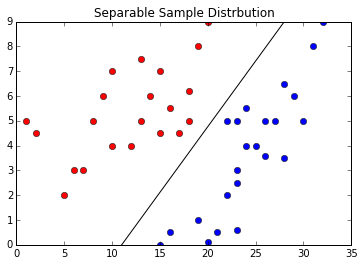

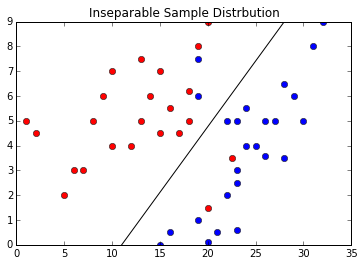

In [125]:
X = getdata_CSV("../data/Data_2D.csv")
sv=None
plot_models(X,sv,"Separable Sample Distrbution")

X = getdata_CSV("../data/Data_2D_mixed.csv")
sv=None
plot_models(X,sv,"Inseparable Sample Distrbution")


### Gaussian Kernel 
$ K(X^{(i)},X^{(j)}) = \exp ^{(-1/\sigma (X^i-X^j)^T . (X^i-X^j))} $

In [7]:
def gaussian_kernel(xi, xj, sigma=2.0):
    return np.exp(-np.linalg.norm(xi-xj)**2 / (2 * (sigma ** 2)))

###Polynomial Kernel 
$ K(X^{(i)},X^{(j)}) = (X^{(i)^T}. X^{(j)} + 1 )^q $

In [8]:
def polynomial_kernel(xi, xj, q=3):
    return (1 + np.dot(xi, xj)) ** q

### Linear Kernel 
$ K(X^{(i)},X^{(j)}) = (X^{(i)^T}. X^{(j)}) $


In [9]:
def linear_kernel(xi, xj):
    return np.dot(xi, xj)


In [10]:
def evaluate_performance(y_Cap,y,cls):
    """ Using the Confusion matrix , the metric like Accuracy , Precision , Recall , F square measures are computed """
    a,b,c,d = confussion_matrix(y_Cap,y,cls)
    r =0 
    p= 0
    if a+b+c+d!=0:
        print "Accuracy \t:",(a+d)/(a+b+c+d)
    else: 
        print "Can't Compute Accurancy"
    if c+d !=0:
        
        r = (d)/(c+d)
        print "Recall  \t:",r
        print "False Negative \t:",c/(c+d)
    else: 
        print "Can't Compute Recall and False Negative"
        r=0
    if b+d!=0:    
        p = d/(b+d)
        print "Precision \t:",p
    else: 
        print "Can't Compute Precision "
        p=0
    if a+b!=0:
        print "False Positive \t:",b/(a+b)
        print "True Negative \t:",a/(a+b)
    else:
         print "Can't Compute False Positive and True Negatice"
    if p+r !=0:
        print "F Square \t:",2*(p*r)/(p+r)
    else:
        print"Can't Compute F Square"
    return p,r

In [12]:
def confussion_matrix(y_cap,y,cls=1):
    """ Compute the confussion matrix for the given predicted and actual classes """
    a=0
    b=0
    c=0
    d=0
    for i in range(0,len(y)):        
        if y[i]==cls and y_cap[i] ==cls:
            a+=1
        elif y[i]!=cls and y_cap[i] ==cls:
            c+=1
        elif y[i]==cls and y_cap[i] !=cls:
            b+=1
        elif y[i]!=cls and y_cap[i] !=cls:
            d+=1
    return float(a),float(b),float(c),float(d)




### Finding Lagrange multipliers 

Using CVXOPT's Quadratic problem solver  
$ min_x 1/2 X^T P X + q^T X $

### Computing Weights W and W$_0$ 
$ w = \sum_{i=1}^{m}\alpha_i y^{(i)}X^{(i)} $

$ w_0 = 1/sv \sum_{X^i \in SV} ( y^{(i)} - W^T .X^{(i)})  $

In [13]:

def fit(X,Y,c=None,kernel_fn=linear_kernel):
    """Computation of lagrange multipliers using CVXOPT package QP solver
    Input: Data and Label X, Y as NP array, slack c as integer
    Output: Lagrange Mulitpliers vector aplha"""
    
    n_samples, n_features = X.shape

        # Gram matrix
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = kernel_fn(X[i], X[j])
            
    
    p= mul_elemwise(np.dot(Y,np.transpose(Y)),K )
    P=matrix(p.value)

    q= matrix(np.full((len(Y),1), -1))

    l = len(Y)
    print l 

    A= matrix(Y, (1,l))

    b=matrix(0.0)
    if c is not None:
        g1 = np.zeros((l,l))
        np.fill_diagonal(g1, -1)

        g2 = np.zeros((l,l))
        np.fill_diagonal(g2, 1)

        g = np.concatenate((g1,g2),axis=0) 
        G =matrix(g)

        h1= np.zeros((l,1))
        h2= np.full((l,1), c)
        h= matrix(np.concatenate((h1,h2),axis=0))
    else:
        g = np.zeros((len(Y_train),len(Y_train)))
        np.fill_diagonal(g, -1)
        G =matrix(g)

        h=matrix(np.zeros(len(Y_train)))



    q_soln = solvers.qp(P,q,G,h,A,b)
    alphas = np.ravel(q_soln['x'] )
   

    nsv = alphas > 0.000000001
    
    ind = np.arange(len(alphas))[nsv]
    alphas = alphas[nsv]
    
  
    sv = X[nsv]
    sv_y = Y[nsv]



    # Bias W0
    W0 = 0
    for n in range(len(alphas)):
        W0 += sv_y[n]
        W0 -= np.sum(alphas * sv_y * K[ind[n],nsv])
    W0 /= len(alphas)
    
    # W weights 
    
    W=[]
    if kernel_fn == linear_kernel:
        W = np.zeros(X.shape[1])
        for n in range(0,len(alphas)):
            W+=alphas[n] * sv_y[n] * sv[n]
    else:
        W = None

    return alphas,W0,W,sv,sv_y

In [14]:
def predict(alphas,sv,sv_y,w,w0,X_test,kernel=None):
    
    "predicting the labels for Test data "
    if w is not None:
        return np.sign(np.dot(X_test, W) + w0)
    else:
        y_predict  = np.zeros(len(X_test))
        for i in range(len(X_test)):
            temp=0
            for a,sy,s in zip(alphas,sv_y,sv):
                 
                temp+= a*sy* kernel(X_test[i],s)
            y_predict[i] = temp
            
        return np.sign(y_predict)      

30
     pcost       dcost       gap    pres   dres
 0: -1.9867e+00 -3.4177e+00  7e+01  7e+00  2e+00
 1: -1.8539e+00 -5.6995e-01  1e+01  1e+00  3e-01
 2: -5.5769e-02 -9.8809e-04  2e-01  3e-02  7e-03
 3: -1.3101e-03 -5.3670e-04  8e-03  8e-04  2e-04
 4: -3.3900e-05 -3.8881e-04  4e-04  3e-19  2e-15
 5: -1.4075e-04 -2.3367e-04  9e-05  8e-20  7e-16
 6: -2.0931e-04 -2.1716e-04  8e-06  6e-20  7e-16
 7: -2.1551e-04 -2.1559e-04  8e-08  2e-21  5e-16
Optimal solution found.
Accuracy 	: 1.0
Recall  	: 1.0
False Negative 	: 0.0
Precision 	: 1.0
False Positive 	: 0.0
True Negative 	: 1.0
F Square 	: 1.0


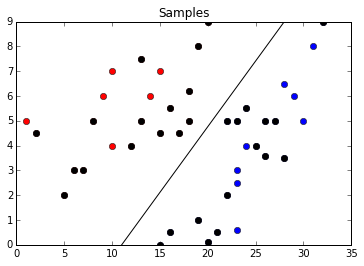

In [291]:
X_train,Y_train,X_test,Y_test = make_data("Data_2D.csv")
alphas,W0,W,sv,sv_y = fit(X_train, Y_train)
y_predict = predict(alphas,sv,sv_y,W,W0,X_test)
evaluate_performance(y_predict,Y_test,1)

X = getdata_CSV("Data_2D.csv")
plot_models(X,sv,"Samples")

In [277]:
alphas,W0,W,sv,sv_y = fit(X_train, Y_train,c=0.4)
y_predict = predict(alphas,sv,sv_y,W,W0,X_test)
evaluate_performance(y_predict,Y_test,1)

30
     pcost       dcost       gap    pres   dres
 0: -1.3016e+00 -1.5194e+01  1e+02  4e+00  2e-12
 1: -6.1102e-01 -9.4090e+00  2e+01  3e-01  2e-12
 2: -3.2218e-01 -2.5553e+00  4e+00  8e-02  5e-13
 3: -9.4397e-03 -6.0640e-01  9e-01  1e-02  2e-13
 4: -9.6404e-05 -1.6046e-02  2e-02  4e-04  2e-14
 5:  7.5502e-05 -5.6790e-04  7e-04  4e-06  6e-16
 6: -3.5414e-05 -3.5211e-04  3e-04  2e-06  6e-16
 7: -1.8896e-04 -3.8661e-04  2e-04  3e-07  6e-16
 8: -2.3326e-04 -2.4249e-04  9e-06  1e-08  8e-16
 9: -2.3721e-04 -2.3730e-04  1e-07  1e-10  5e-16
Optimal solution found.
Accuracy 	: 0.571428571429
Recall  	: 1.0
False Negative 	: 0.0
Precision 	: 0.571428571429
False Positive 	: 1.0
True Negative 	: 0.0
F Square 	: 0.727272727273


(0.5714285714285714, 1.0)

### Inseparable data with Gaussian kernel 

In [185]:
X_train,Y_train,X_test,Y_test = make_data("Data_2D_mixed.csv")

30
     pcost       dcost       gap    pres   dres
 0: -1.8318e-01 -3.2828e+00  7e+01  8e+00  3e-16
 1: -1.7549e-01 -2.8663e+00  3e+00  1e-01  3e-16
 2: -1.6840e-01 -3.1845e-01  2e-01  1e-03  3e-16
 3: -1.7958e-01 -1.8946e-01  1e-02  4e-05  1e-16
 4: -1.8141e-01 -1.8288e-01  1e-03  5e-06  1e-16
 5: -1.8194e-01 -1.8203e-01  9e-05  1e-07  1e-16
 6: -1.8199e-01 -1.8199e-01  2e-06  1e-09  1e-16
 7: -1.8199e-01 -1.8199e-01  2e-08  1e-11  1e-16
Optimal solution found.
Accuracy 	: 1.0
Recall  	: 1.0
False Negative 	: 0.0
Precision 	: 1.0
False Positive 	: 0.0
True Negative 	: 1.0
F Square 	: 1.0


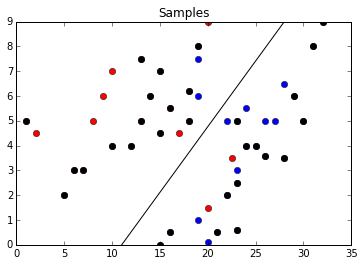

In [266]:
alphas,W0,W,sv,sv_y = fit(X_train, Y_train,c=0.1,kernel_fn=gaussian_kernel)
y_predict = predict(alphas,sv,sv_y,W,W0,X_test,kernel =gaussian_kernel )
evaluate_performance(y_predict,Y_test,1)

X = getdata_CSV("Data_2D_mixed.csv")
plot_models(X,sv,"Samples")

### Inseparable data with linear kernel 

In [62]:
alphas,W0,W,sv,sv_y = fit(X_train, Y_train,c=0.2)

y_predict = predict(alphas,sv,sv_y,W,W0,X_test)
evaluate_performance(y_predict,Y_test,1)

30
     pcost       dcost       gap    pres   dres
 0: -1.2135e+00 -7.4741e+00  1e+02  9e+00  3e-12
 1: -3.7700e-01 -5.7090e+00  1e+01  5e-01  1e-12
 2: -1.2954e-01 -1.1285e+00  2e+00  7e-02  4e-13
 3: -1.3194e-02 -1.7465e-01  2e-01  1e-02  1e-13
 4: -2.5200e-04 -3.6763e-03  5e-03  2e-04  2e-14
 5: -9.6647e-05 -3.0954e-04  2e-04  2e-06  7e-16
 6: -1.8402e-04 -2.2832e-04  5e-05  3e-07  5e-16
 7: -2.1508e-04 -2.1599e-04  9e-07  4e-09  4e-16
 8: -2.1557e-04 -2.1558e-04  9e-09  4e-11  5e-16
Optimal solution found.
Accuracy 	: 0.666666666667
Recall  	: 1.0
False Negative 	: 0.0
Precision 	: 0.6
False Positive 	: 0.666666666667
True Negative 	: 0.333333333333
F Square 	: 0.75


(0.6, 1.0)

### Experimentation using external datasets

#### 1.  Two class data containing features that classifies good vs bad credit scores

In [122]:
externaldata = getdata_CSV("../data/credit_Score.csv") 
X_Train = externaldata[:200,[1,2,4]]
Y_Train = externaldata[:200,15]
X_Test = externaldata[200:300,[1,2,4]]
Y_Test = externaldata[200:300,15]

In [123]:
count = 0
for i in (Y_Train):
    if i==1:
        count +=1
    
print "Number of samples with class 1 ",count ,"Number of samples with class 2 ",len(Y_Train)-count      

Number of samples with class 1  158 Number of samples with class 2  42


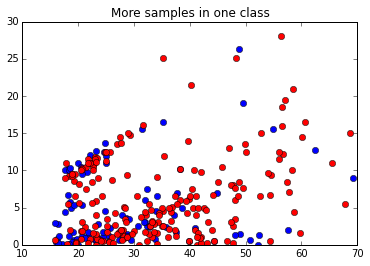

In [124]:
plot_models(externaldata[:300,[1,2,15]],None,"More samples in one class",None)

In [131]:
alphas,W0,W,sv,sv_y = fit(X_Train, Y_Train,c=0.02,kernel_fn=gaussian_kernel)

y_predict = predict(alphas,sv,sv_y,W,W0,X_Test,kernel=gaussian_kernel)
evaluate_performance(y_predict,Y_Test,1)

print "Print the Label of Support Vectors" , len(sv_y[sv_y==0]),len(sv_y[sv_y==1]) 


200
     pcost       dcost       gap    pres   dres
 0: -1.2183e-01 -4.1613e+00  4e+02  2e+01  1e-15
 1: -1.1960e-01 -4.0151e+00  1e+01  3e-01  6e-16
 2: -1.0480e-01 -1.4855e+00  2e+00  5e-02  6e-16
 3: -7.2266e-02 -3.5100e-01  4e-01  8e-03  1e-15
 4: -6.0402e-02 -7.9606e-02  2e-02  4e-04  6e-16
 5: -6.0531e-02 -6.2920e-02  3e-03  5e-05  6e-16
 6: -6.0666e-02 -6.0843e-02  2e-04  2e-06  4e-16
 7: -6.0688e-02 -6.0708e-02  2e-05  1e-07  4e-16
 8: -6.0690e-02 -6.0691e-02  4e-07  2e-09  4e-16
 9: -6.0690e-02 -6.0690e-02  2e-08  2e-11  4e-16
Optimal solution found.
Accuracy 	: 0.53
Recall  	: 1.0
False Negative 	: 0.0
Precision 	: 0.53
False Positive 	: 1.0
True Negative 	: 0.0
F Square 	: 0.692810457516
Print the Label of Support Vectors 39 0


>When we take dataset that is skewed towards one class , the accuracy drastically reduces. 

>Another reason that lead to the reduction in accuracy is that only few features of the whole dataset is used , which makes the classification weak as well. 


### Spam Vs Not Spam Dataset 

In [135]:
externaldata = getdata_CSV("../data/spambase.csv") 
 
X_Train = externaldata[:400,[1,2]]
Y_Train = externaldata[:400,externaldata.shape[1]-1]
X_Test = externaldata[400:500,[1,2]]
Y_Test = externaldata[400:500,externaldata.shape[1]-1]

In [136]:
count = 0
for i in (Y_Train):
    if i==1:
        count +=1
    
print "Number of samples with class 1 ",count ,"-- Number of samples with class 2 ",len(Y_Train)-count  

Number of samples with class 1  174 -- Number of samples with class 2  226


In [137]:
alphas,W0,W,sv,sv_y = fit(X_Train, Y_Train,c=0.02,kernel_fn=gaussian_kernel)

y_predict = predict(alphas,sv,sv_y,W,W0,X_Test,kernel=gaussian_kernel)
evaluate_performance(y_predict,Y_Test,1)

400
     pcost       dcost       gap    pres   dres
 0: -9.2357e-03 -8.0231e+00  8e+02  3e+01  2e-15
 1: -9.0627e-03 -7.7167e+00  2e+01  3e-01  1e-15
 2: -4.9961e-03 -1.2366e+00  1e+00  9e-03  5e-16
 3: -5.1470e-03 -5.4261e-02  5e-02  3e-04  7e-16
 4: -6.7857e-03 -1.5928e-02  1e-02  4e-05  7e-16
 5: -7.1334e-03 -9.9096e-03  3e-03  1e-05  7e-16
 6: -7.1703e-03 -9.7193e-03  3e-03  1e-05  5e-16
 7: -7.3301e-03 -8.3071e-03  1e-03  2e-06  1e-15
 8: -7.3848e-03 -7.4786e-03  1e-04  2e-07  3e-15
 9: -7.3914e-03 -7.3949e-03  4e-06  4e-09  6e-16
10: -7.3915e-03 -7.3916e-03  4e-08  4e-11  5e-16
Optimal solution found.
Accuracy 	: 0.63
Recall  	: 1.0
False Negative 	: 0.0
Precision 	: 0.63
False Positive 	: 1.0
True Negative 	: 0.0
F Square 	: 0.773006134969


(0.63, 1.0)